In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-segmentation-tutorial-in-python:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F42674%2F74935%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T084357Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b7fad30162c85efb6492717581c8369db0422f741486c1e1e1e472feb820a17d72fc728849921f4a147fa5cc3758af719287b01f523486386efe576a0a3c82a50f7b1071f664376dbcf7c04eeef0a8907d18a46e5fd5e2b8a2130c4877f6ea721fbc2f005de3fc5ba1a1f75216f86630c6882dfd15f9d55ebda09a743bdf423099b3bba7fd353482b3f4e7b168707953aabbbea907b0453775288f016d93648f866c57c7295aa0ea842cc2da1a993c4efe55f8842eaa03b146c9f2b4ca52c92e8442c9687f2de01b1a910283e75502bf6ad48161dae716d38c12eacc750f0301db22e3c645228c9c192808391933b39389596b4f26460049a9b90bd74799dbb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1583 bytes downloaded
Downloaded and uncompressed: customer-segmentation-tutorial-in-python
Data source import complete.


## **Customer Segmentation for targeted Matrketing**

**Loading the Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Reading the Dataset**

In [3]:
df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Shape of the Dataset**

In [4]:
df.shape

(200, 5)

**Sample of the Datset**

In [5]:
df.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
140,141,Female,57,75,5
193,194,Female,38,113,91
187,188,Male,28,101,68
9,10,Female,30,19,72
80,81,Male,57,54,51
189,190,Female,36,103,85
26,27,Female,45,28,32
130,131,Male,47,71,9
167,168,Female,33,86,95
44,45,Female,49,39,28


## **Exploratory Data Analysis (EDA)**

**Info of the DataSet**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**Checking Missing Values**

In [7]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

*We have no missing Values in the DataSet.*

**Pairwise relationship between Variables of the Dataset**

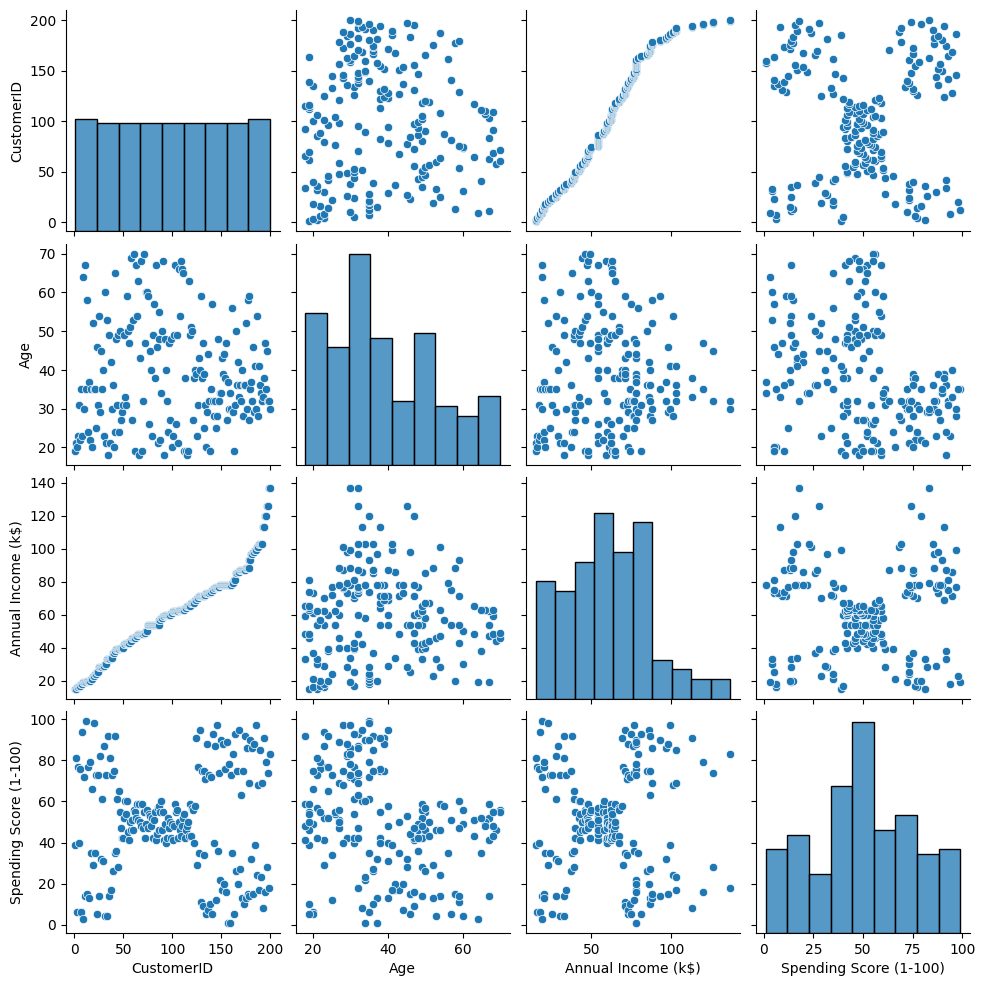

In [8]:
sns.pairplot(df)
plt.show()

**Correlation**

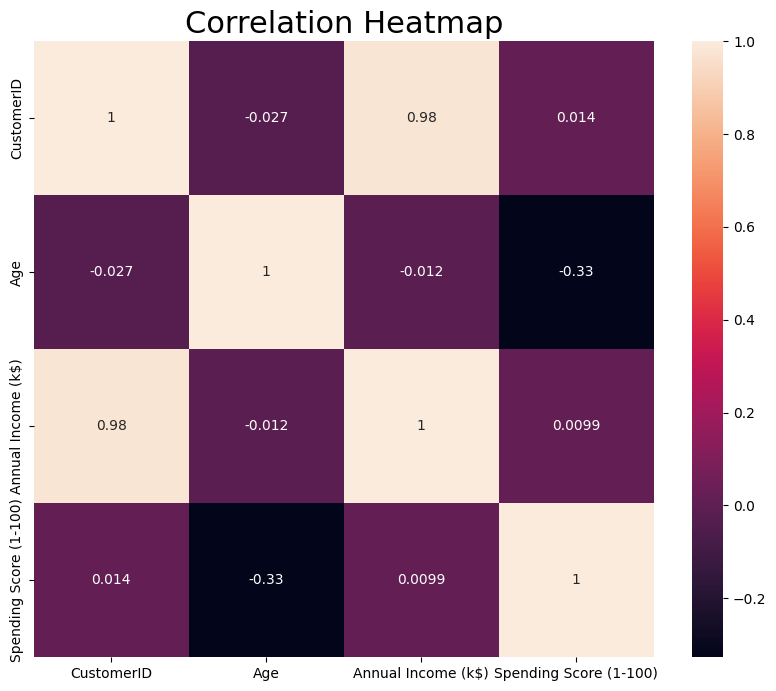

In [9]:
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap", fontsize = 22)
plt.show()

*No multicolinearity as per the Correlation*

**Analyzing the data with respect to "Spending Score"**

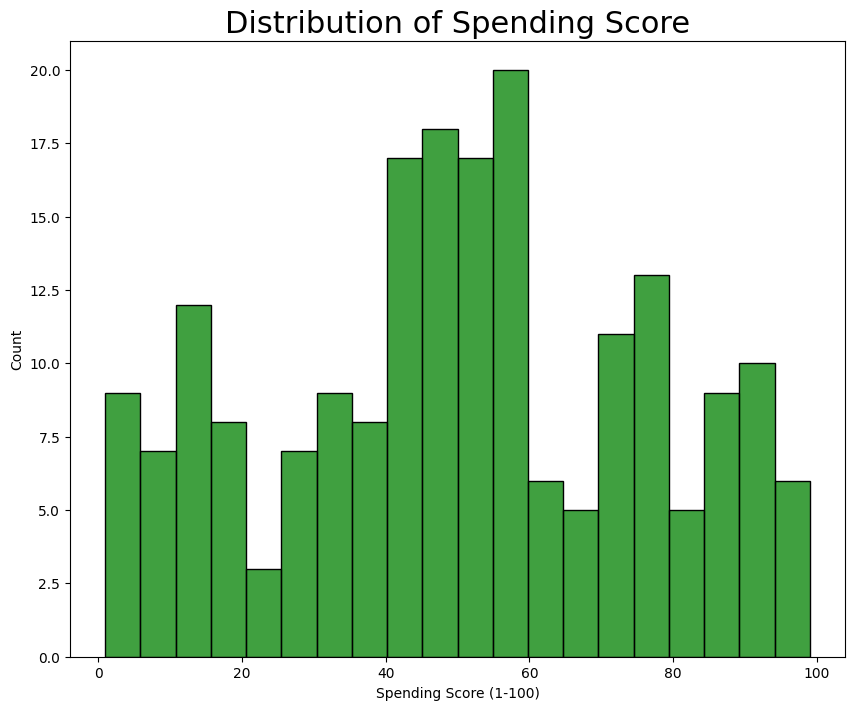

In [10]:
plt.figure(figsize=(10,8))
sns.histplot(df['Spending Score (1-100)'], bins= 20, color='g')
plt.title("Distribution of Spending Score", fontsize = 22)
plt.show()

*Customers have high spending score between 40 to 60*

**Distribution of Spending Score with respect to Age**

<Figure size 1200x1000 with 0 Axes>

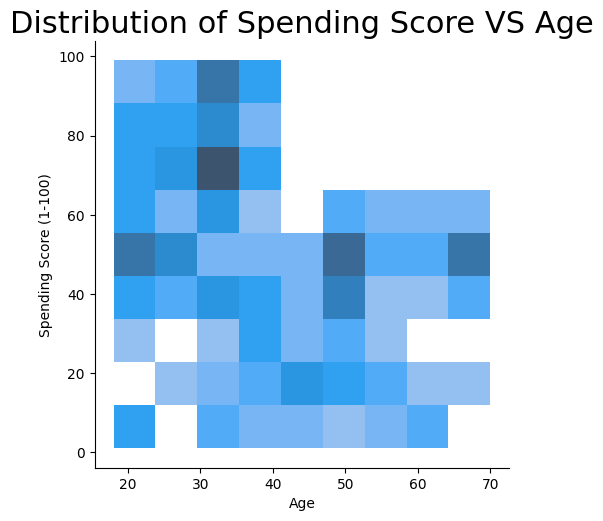

In [11]:
plt.figure(figsize=(12,10))
sns.displot(data= df,y='Spending Score (1-100)',x='Age')
plt.title("Distribution of Spending Score VS Age", fontsize = 22)
plt.show()

*The Age of Customer from 20 to 40 have high Spending Score*

**Distribution of Spending Score with respect to Annual Income**

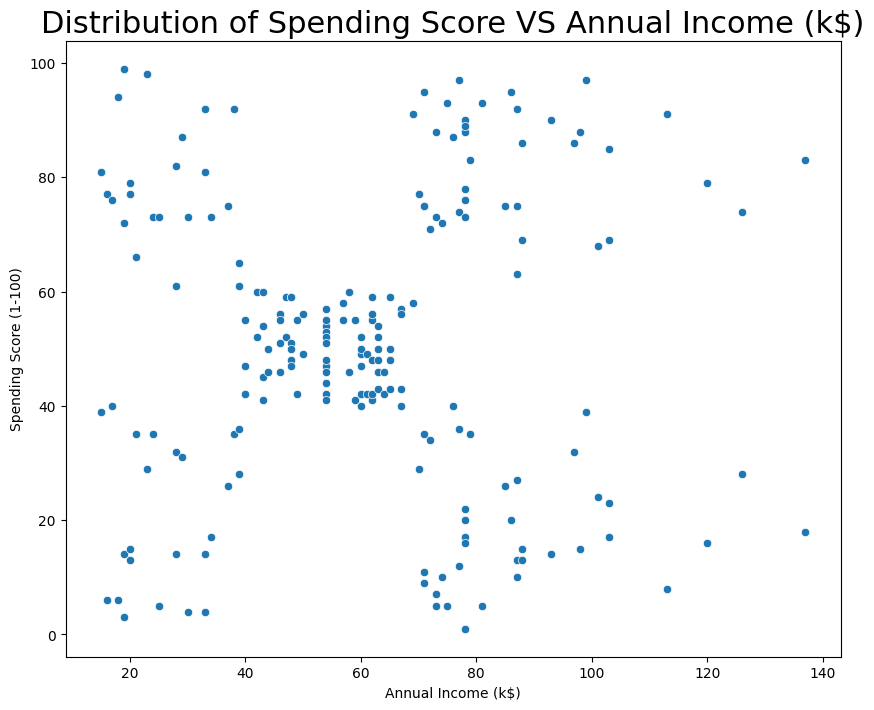

In [12]:
plt.figure(figsize=(10,8))
sns.scatterplot(data= df,y='Spending Score (1-100)',x='Annual Income (k$)')
plt.title("Distribution of Spending Score VS Annual Income (k$)", fontsize = 22)
plt.show()

*Customers having Annual Income range 20k to 40k and 80k to 100k have higher Spending Score. And a big chunk of customers are around ~50k income with ~50 Spending Score*

**Analyzing the data with respect to "Annual Income"**

**Distribution of Annual Income**

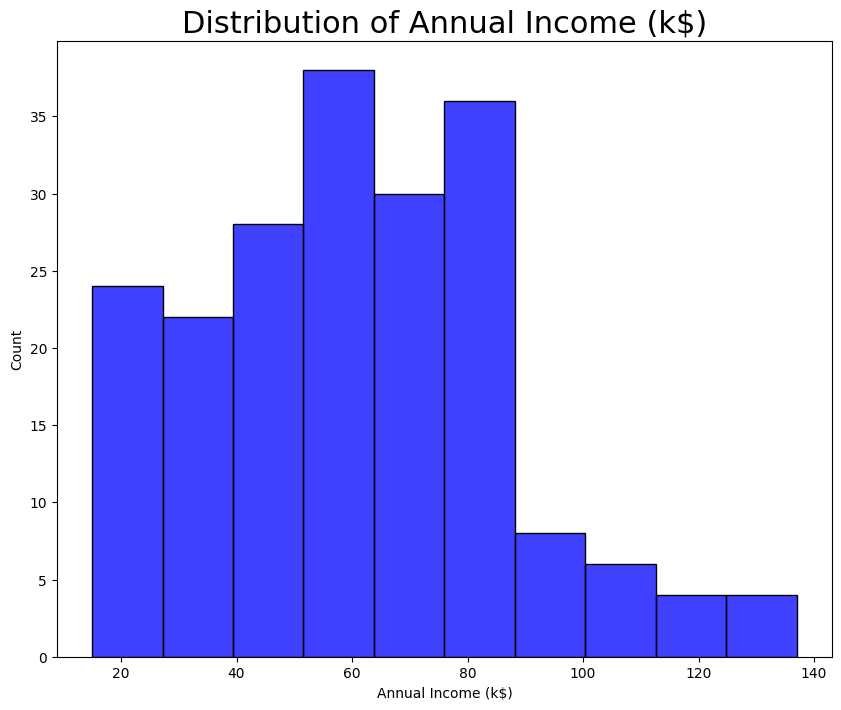

In [13]:
plt.figure(figsize=(10,8))
sns.histplot(df['Annual Income (k$)'], color='b')
plt.title("Distribution of Annual Income (k$)", fontsize = 22)
plt.show()

*Most customers visiting Mall have Annual Income of 50k to 80k.*

**Distributuion Annual Income with respect to Age**

<Figure size 1200x1000 with 0 Axes>

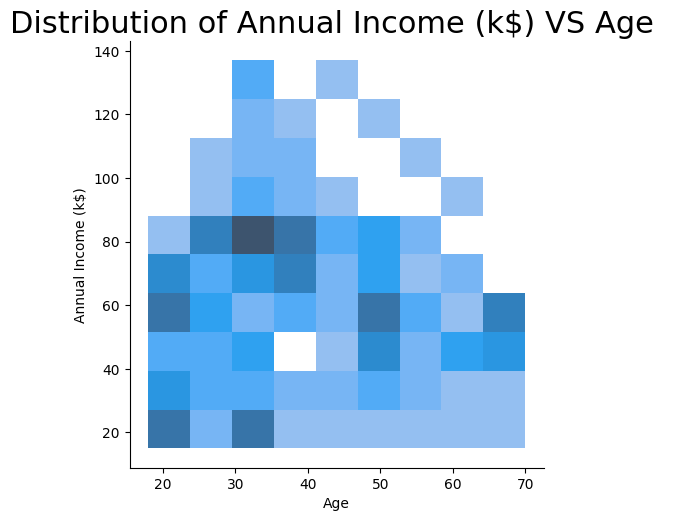

In [14]:
plt.figure(figsize=(12,10))
sns.displot(data= df,y='Annual Income (k$)',x='Age')
plt.title("Distribution of Annual Income (k$) VS Age ", fontsize = 22)
plt.show()

*High Annual Income Customers are around the age of 30 to 45.*

**Average Income distribution by Gender**

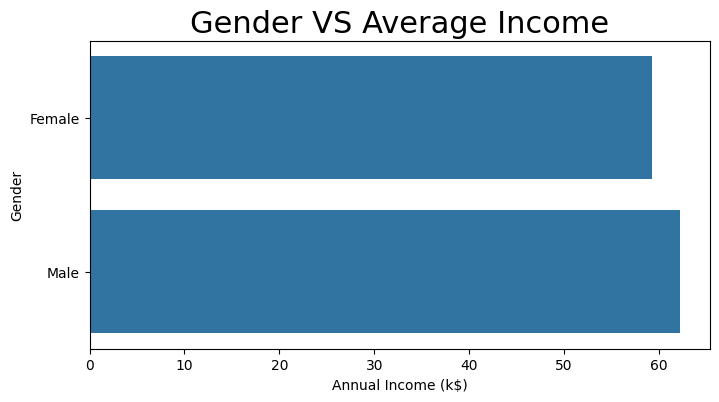

In [15]:
gender_income = df.groupby('Gender')['Annual Income (k$)'].agg('mean').reset_index()
plt.figure(figsize=(8,4))
sns.barplot(data= gender_income, y='Gender', x='Annual Income (k$)')
plt.title("Gender VS Average Income", fontsize = 22)
plt.show()

*Males have more average Annual Income than Females*

**Descriptive Statistics**

In [16]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**Categorical Distribution**

In [17]:
df.select_dtypes("object").describe()

,Gender
count,200
unique,2
top,Female
freq,112


**Gender Distribution**

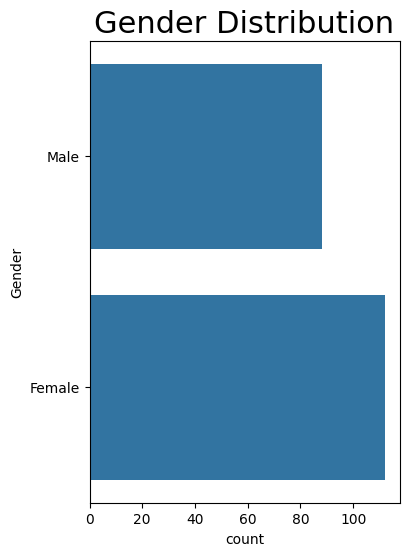

In [18]:
plt.figure(figsize=(4,6))
sns.countplot(df['Gender'])
plt.title("Gender Distribution", fontsize = 22)
plt.show()

**Distribution of Annual Income & Age**

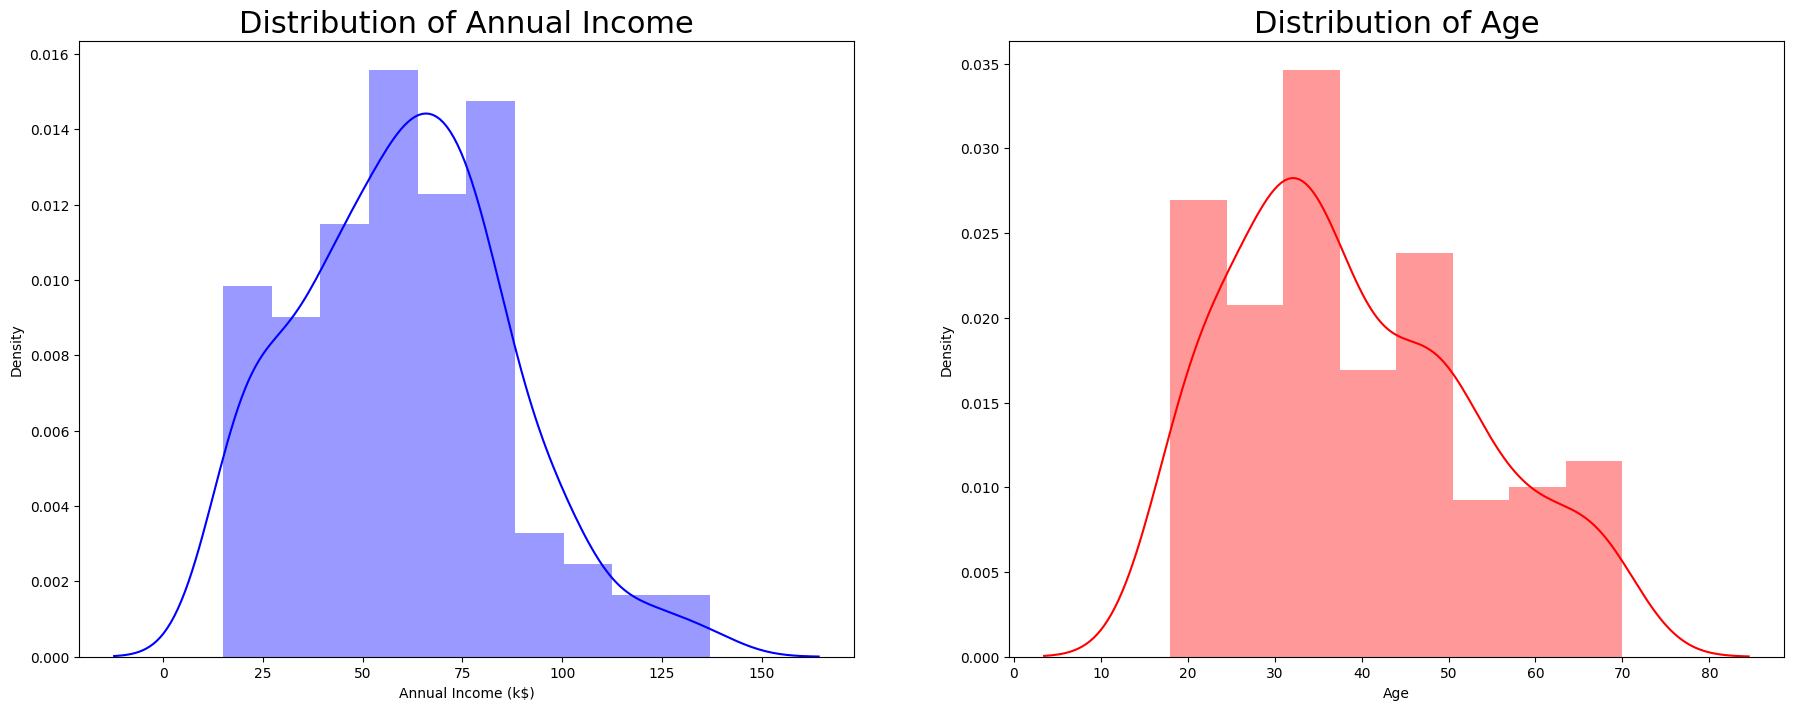

In [19]:
plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
sns.distplot(df['Annual Income (k$)'], color='b')
plt.title("Distribution of Annual Income", fontsize = 22)

plt.subplot(1,2,2)
sns.distplot(df['Age'], color='r')
plt.title("Distribution of Age", fontsize = 22)
plt.show()

***Finally, Successfully Segmented our Customers According to their Behaviors using Clustering Technique***